In [0]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse 

E: Package 'python-software-properties' has no installation candidate


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/AI_COLAB/attention_keras

/content/drive/My Drive/AI_COLAB/attention_keras


In [0]:
%tensorflow_version 1.15.0

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [0]:
os.path.dirname(path_to_zip)

'/root/.keras/datasets'

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer



In [0]:
# en, sp = create_dataset(path_to_file, None)
# Try experimenting with the size of that dataset
num_examples = 120000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.3)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


83274 83274 35690 35690


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> no
47 ----> quiero
53 ----> hacer
57 ----> esto
18 ----> ,
94 ----> pero
8 ----> no
17 ----> me
2727 ----> dejas
34 ----> mas
2511 ----> alternativa
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
30 ----> don
12 ----> t
39 ----> want
6 ----> to
21 ----> do
23 ----> this
20 ----> ,
96 ----> but
7 ----> you
174 ----> leave
24 ----> me
75 ----> no
742 ----> choice
3 ----> .
2 ----> <end>


In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer, Input, GRU, Embedding, Dense, Bidirectional, TimeDistributed, Concatenate, Dropout
from keras.regularizers import l2
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import Model
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.optimizers import Adam
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq, input_enc = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        # comupte mask
        # batch, max_sent, max_arg
        mask_val = K.equal(input_enc, 0)
        # batch, 1, 
        all_padding = K.all(mask_val, axis=-1)
        all_padding = K.cast(all_padding, K.floatx())
        all_padding = K.expand_dims(all_padding, axis=-1)
        # batch, max_arg
        mask_val = 1 - K.cast(mask_val, dtype=K.floatx())
        print('all pad: ', all_padding)
        print(mask_val)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            print('e_i: ',e_i)
            expo = K.exp(e_i - K.max(e_i, axis =-1, keepdims=True))
            print(expo)            
            expo = expo * mask_val
            print(expo)
            sum_expo = K.sum(expo, axis=-1, keepdims=True) + all_padding
            print(sum_expo)
            e_i = expo / sum_expo
            # <= batch_size, en_seq_len
            # e_i = K.softmax(e_i)
            print('weight enc: ',e_i)
            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

Using TensorFlow backend.


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
rate_val = 0.2
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

In [0]:
import logging
import logging.config
import yaml
import os


def get_logger(mod_name, log_dir):
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

    config_filepath = os.path.join('./', 'logger_config.yml')
    if os.path.exists(config_filepath):
        with open(config_filepath, 'r') as f:
            config = yaml.safe_load(f.read())
            config["handlers"]["file"]["filename"] = os.path.join(log_dir, mod_name+'.log')
            logging.config.dictConfig(config)
    else:
        logging.basicConfig(level=logging.INFO)

    logger = logging.getLogger(mod_name)
    logger.info("Started log {}".format(os.path.join(log_dir, mod_name)))
    return logger

In [0]:
logger = get_logger('test','test')

INFO:test:Started log test/test


In [0]:
enc_input = Input(shape=(max_length_inp,), dtype='int32')
dec_input = Input(shape=(max_length_targ-1,), dtype='int32')

enc_embedding_seqs = Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim, mask_zero=True)(enc_input)
dec_embedding_seqs = Embedding(input_dim=vocab_tar_size, output_dim=embedding_dim, mask_zero=True)(dec_input)

enc_out, enc_fw_state, enc_bw_state = Bidirectional(GRU(units=units, kernel_regularizer=l2(1e-5), activity_regularizer=l2(1e-5), return_sequences=True, return_state=True))((enc_embedding_seqs))
enc_h_state = Concatenate(axis=-1)([enc_fw_state, enc_bw_state])
enc_h_state = Dropout(0.35)(enc_h_state)
enc_out = Dropout(0.35)(enc_out)
dec_out, dec_state = GRU(units=units*2, return_sequences=True, return_state=True)(
    dec_embedding_seqs, initial_state=enc_h_state)
atn_out, atn_state = AttentionLayer()([enc_out,dec_out, enc_input])

output = Concatenate()([dec_out, atn_out])
output = Dropout(0.35)(output)
output = TimeDistributed(Dense(units=vocab_tar_size, activation='softmax', activity_regularizer=l2(1e-4)))(output)
model = Model(inputs=[enc_input, dec_input], outputs=output)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

all pad:  Tensor("attention_layer_1/ExpandDims:0", shape=(?, 1), dtype=float32)
Tensor("attention_layer_1/sub:0", shape=(?, 53), dtype=float32)
e_i:  Tensor("attention_layer_1/Reshape_3:0", shape=(?, 53), dtype=float32)
Tensor("attention_layer_1/Exp:0", shape=(?, 53), dtype=float32)
Tensor("attention_layer_1/mul:0", shape=(?, 53), dtype=float32)
Tensor("attention_layer_1/add_1:0", shape=(?, 1), dtype=float32)
weight enc:  Tensor("attention_layer_1/truediv:0", shape=(?, 53), dtype=float32)
e_i:  Tensor("attention_layer_1/while/Reshape_3:0", shape=(?, 53), dtype=float32)
Tensor("attention_layer_1/while/Exp:0", shape=(?, 53), dtype=float32)
Tensor("attention_layer_1/while/mul:0", shape=(?, 53), dtype=float32)
Tensor("attention_layer_1/while/add_1:0", shape=(?, 1), dtype=float32)
weight enc:  Tensor("attention_layer_1/while/truediv:0", shape=(?, 53), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (typ

In [0]:
# from tensorflow.python.keras.models import model_from_json
# model.load_weights('./results/nmt_atn_20_0.0007246376811594204.h5')
# K.set_value(model.optimizer.lr, 0.0007246376811594204)

In [0]:
import time
with open('./results/log.txt', 'w') as f:
    f.write('mnt log 1:\n')

In [0]:
f1_max = 0
n_epochs = 5
nepoch_no_improve = 0
for epoch in range(n_epochs):
    losses = []
    start = time.time()
    for bi in range(0, int(input_tensor_train.shape[0]/BATCH_SIZE)):
        enc_input_seq = input_tensor_train[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        dec_input_seq = target_tensor_train[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        loss = model.train_on_batch(x=[enc_input_seq, dec_input_seq[:,:-1]], y=to_categorical(dec_input_seq[:,1:], num_classes=vocab_tar_size))[0]
        losses.append(loss)
        if bi%100==0:
            logger.info('{}/{} Loss: {:.4f}'.format(bi, epoch, np.mean(loss)))
    timetraining = time.time()-start
    val_av = []
    for bi in range(0, int(input_tensor_val.shape[0]/BATCH_SIZE)):
        enc_input_seq = input_tensor_val[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        dec_input_seq = target_tensor_val[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        val = model.evaluate(x=[enc_input_seq, dec_input_seq[:,:-1]], y=to_categorical(dec_input_seq[:,1:], num_classes=vocab_tar_size), batch_size=BATCH_SIZE, verbose=0)[1]
        val_av.append(val)
    logger.info('Epoch {} takes {}, {} ms/step, loss av: {:.4f}, validation acc: {:.3f}'.format(epoch, timetraining, 1000*timetraining/int(input_tensor_train.shape[0]/BATCH_SIZE),np.mean(losses), np.mean(val_av)))
    if np.mean(val_av) > f1_max:
        model.save_weights('./results/nmt_atn_{}_{}.h5'.format(epoch+1, 0.001/(1+ 0.02*epoch)))
        f1_max = np.mean(val_av)
        print('new best score!')
        with open('./results/log.txt', 'a') as f:
            f.write('Epoch {} loss {}, acc_val: {} \n ----New best score\n'.format(epoch, np.mean(losses), np.mean(val_av)))
    else:
        nepoch_no_improve +=1
        print('no improve {} times'.format(nepoch_no_improve))
        with open('./results/log.txt', 'a') as f:
            f.write('Epoch {} loss {}, acc_val: {} \n'.format(epoch, np.mean(losses), np.mean(val_av)))        
    K.set_value(model.optimizer.lr, 0.001/(1+ 0.02*epoch))

INFO:test:0/0 Loss: 1.8355
INFO:test:100/0 Loss: 0.7906
INFO:test:200/0 Loss: 0.6786
INFO:test:300/0 Loss: 0.6018
INFO:test:400/0 Loss: 0.5824
INFO:test:500/0 Loss: 0.5077
INFO:test:600/0 Loss: 0.3992
INFO:test:Epoch 0 takes 1707.6360294818878, 2627.132353049058 ms/step, loss av: 0.6631, validation acc: 0.627


new best score!


INFO:test:0/1 Loss: 0.4326
INFO:test:100/1 Loss: 0.3874
INFO:test:200/1 Loss: 0.3660
INFO:test:300/1 Loss: 0.3209
INFO:test:400/1 Loss: 0.3432
INFO:test:500/1 Loss: 0.3133
INFO:test:600/1 Loss: 0.2413
INFO:test:Epoch 1 takes 1699.012951850891, 2613.8660797706016 ms/step, loss av: 0.3585, validation acc: 0.730


new best score!


INFO:test:0/2 Loss: 0.2880
INFO:test:100/2 Loss: 0.2562
INFO:test:200/2 Loss: 0.2536
INFO:test:300/2 Loss: 0.2171
INFO:test:400/2 Loss: 0.2406
INFO:test:500/2 Loss: 0.2256
INFO:test:600/2 Loss: 0.1789
INFO:test:Epoch 2 takes 1703.8067767620087, 2621.241195018475 ms/step, loss av: 0.2471, validation acc: 0.768


new best score!


INFO:test:0/3 Loss: 0.2136
INFO:test:100/3 Loss: 0.1953
INFO:test:200/3 Loss: 0.1807
INFO:test:300/3 Loss: 0.1643
INFO:test:400/3 Loss: 0.1782
INFO:test:500/3 Loss: 0.1759
INFO:test:600/3 Loss: 0.1310
INFO:test:Epoch 3 takes 1704.2437191009521, 2621.913414001465 ms/step, loss av: 0.1849, validation acc: 0.786


new best score!


INFO:test:0/4 Loss: 0.1637
INFO:test:100/4 Loss: 0.1511
INFO:test:200/4 Loss: 0.1479
INFO:test:300/4 Loss: 0.1270
INFO:test:400/4 Loss: 0.1310
INFO:test:500/4 Loss: 0.1404
INFO:test:600/4 Loss: 0.1091
INFO:test:Epoch 4 takes 1701.0506930351257, 2617.0010662078857 ms/step, loss av: 0.1454, validation acc: 0.794


new best score!


In [0]:
n_epochs = 50
nepoch_no_improve = 0
for epoch in range(20,n_epochs):
    losses = []
    start = time.time()
    for bi in range(0, int(input_tensor_train.shape[0]/BATCH_SIZE)):
        enc_input_seq = input_tensor_train[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        dec_input_seq = target_tensor_train[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        loss = model.train_on_batch(x=[enc_input_seq, dec_input_seq[:,:-1]], y=to_categorical(dec_input_seq[:,1:], num_classes=vocab_tar_size))[0]
        losses.append(loss)
        if bi%100==0:
            logger.info('{}/{} Loss: {:.4f}'.format(bi, epoch, np.mean(loss)))
    timetraining = time.time()-start
    val_av = []
    for bi in range(0, int(input_tensor_val.shape[0]/BATCH_SIZE)):
        enc_input_seq = input_tensor_val[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        dec_input_seq = target_tensor_val[bi*BATCH_SIZE:(bi+1)*BATCH_SIZE]
        val = model.evaluate(x=[enc_input_seq, dec_input_seq[:,:-1]], y=to_categorical(dec_input_seq[:,1:], num_classes=vocab_tar_size), batch_size=BATCH_SIZE, verbose=0)[1]
        val_av.append(val)
    logger.info('Epoch {} takes {}, {} ms/step, loss av: {:.4f}, validation acc: {:.3f}'.format(epoch, timetraining, 1000*timetraining/int(input_tensor_train.shape[0]/BATCH_SIZE),np.mean(losses), np.mean(val_av)))
    if np.mean(val_av) > f1_max:
        model.save_weights('./results/nmt_atn_{}_{}.h5'.format(epoch+1, 0.001/(1+ 0.02*epoch)))
        f1_max = np.mean(val_av)
        print('new best score!')
        with open('./results/log.txt', 'a') as f:
            f.write('Epoch {} loss {}, acc_val: {} \n ----New best score'.format(epoch, np.mean(losses), np.mean(val_av)))
    else:
        nepoch_no_improve +=1
        print('no improve {} times'.format(nepoch_no_improve))
        with open('./results/log.txt', 'a') as f:
            f.write('Epoch {} loss {}, acc_val: {} \n'.format(epoch, np.mean(losses), np.mean(val_av)))        
    K.set_value(model.optimizer.lr, 0.001/(1+ 0.02*epoch))

In [0]:
new_model = Model(inputs=model.input, outputs=model.get_layer(model.layers[7].name).output)

In [0]:
bi=1
enc_input_seq = input_tensor_val[bi:bi+BATCH_SIZE]
dec_input_seq = target_tensor_val[bi:bi+BATCH_SIZE]
pred = new_model.predict([enc_input_seq, dec_input_seq[:,:-1]], batch_size=BATCH_SIZE)

In [0]:
model.save_weights('nmt_atn.h5')

In [0]:
for i, layer in enumerate(model.layers):
    print(i, '-', layer)

0 - <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7d78848fd0>
1 - <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f7d78848da0>
2 - <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f7d7895d668>
3 - <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7d78848898>
4 - <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f7d70198748>
5 - <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f7d78848780>
6 - <tensorflow.python.keras.layers.core.Dropout object at 0x7f7d7884e1d0>
7 - <tensorflow.python.keras.layers.recurrent.GRU object at 0x7f7d78951d30>
8 - <tensorflow.python.keras.layers.core.Dropout object at 0x7f7d70175f98>
9 - <__main__.AttentionLayer object at 0x7f7d70186438>
10 - <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f7d70123748>
11 - <tensorflow.python.keras.layers.core.Dropout object at 0x7f7d701236a0>
12 - <tensorflow.python.keras.layers.wrappers.TimeDistributed

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def visualize_attention(id_atn, data):

    length = np.sum(1-np.equal(data[1],0).astype(int))-1
    length_arg = np.sum(1-np.equal(data[0],0).astype(int))

    predict_ = model.predict(data, batch_size=1, verbose=1)
    predict_ = np.argmax(predict_, axis=-1)
    inp_ = ''
    for i_word in data[0][0][:length_arg]:
        inp_ +=inp_lang.index_word.get(i_word)+' '
    print('->Input: %s' % (inp_))

    pred = ''
    for i_word in predict_[0]:
        if i_word ==0:
            pred+='- '
        else:
            pred+=targ_lang.index_word.get(i_word)+' '
    print('->Predict: %s' % (pred))

    real_target = ''
    for i_word in data[1][0,:length+1]:
        real_target+=targ_lang.index_word.get(i_word)+' '
    print('->Real target: %s' % (real_target))
    
    new_model = Model(inputs=model.input,
                  outputs=model.get_layer(model.layers[id_atn].name).output)
    atn_w = new_model.predict(data, batch_size=1, verbose=1)
    confusion_matrix = atn_w[1][0][:length, :length_arg]

    # print(confusion_matrix.shape)
    # df = pd.DataFrame(confusion_matrix,word, args)
    # sn.set(font_scale=0.4)#for label size
    # svm = sn.heatmap(df, annot=True, annot_kws={"size": 3})# font size
    # figure = svm.get_figure()    
    # figure.savefig('./results/elmo_atn_dep_arg_focus.png', dpi=600)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(confusion_matrix, cmap='viridis')

    fontdict = {'fontsize': 8}

    ax.set_xticklabels([''] + inp_.split(), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + pred.split(), fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

    return atn_w


1/1 [==============================] - 0s 148ms/sample
->Input: <start> creo que los dos sabemos como se siente tom . <end> 
->Predict: i think we both know that tom feels . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i think we both know how tom feels . <end> 
1/1 [==============================] - 1s 914ms/sample


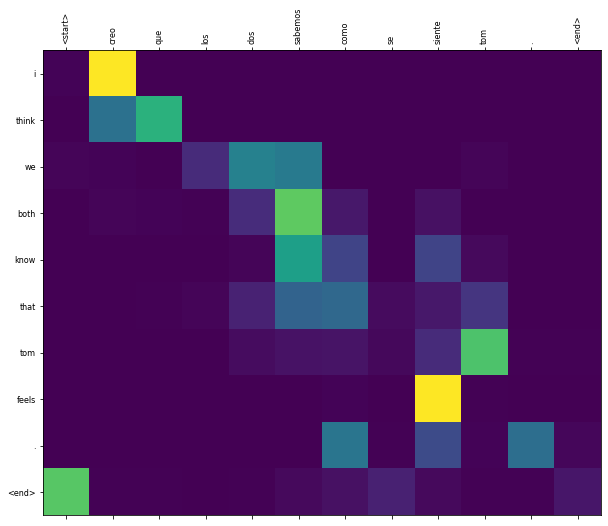

1/1 [==============================] - 0s 152ms/sample
->Input: <start> vamos hacia casa . <end> 
->Predict: we re going our house . . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> we re on the way home . <end> 
1/1 [==============================] - 1s 929ms/sample


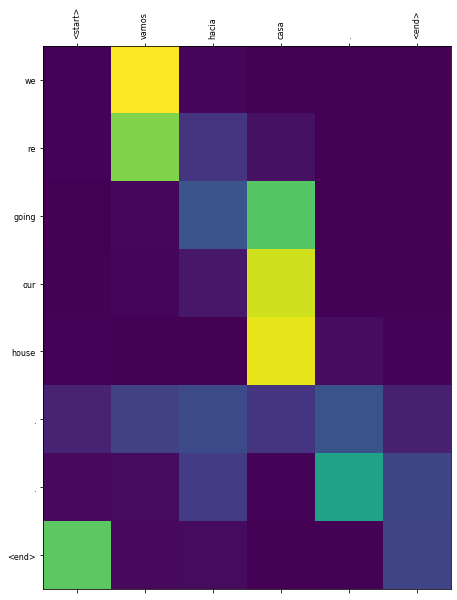

1/1 [==============================] - 0s 147ms/sample
->Input: <start> ¿ que diferencia tiene eso de lo que acabo de decir ? <end> 
->Predict: what difference that that thing what s just say ? <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> how is that different from what i just said ? <end> 
1/1 [==============================] - 1s 915ms/sample


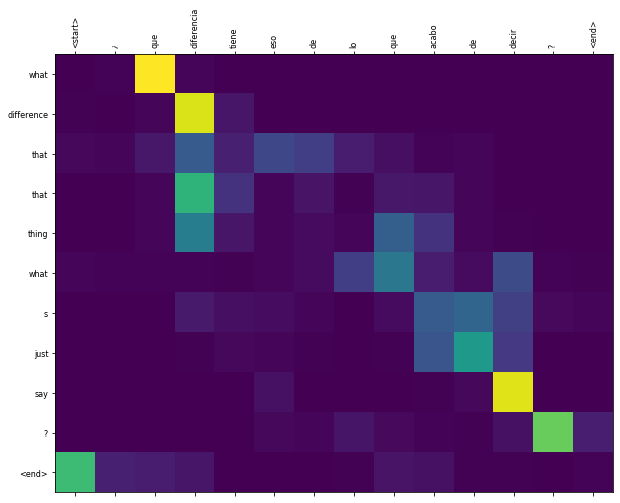

1/1 [==============================] - 0s 149ms/sample
->Input: <start> tom siempre trata de culpar a otro por sus errores . <end> 
->Predict: tom always tries to blame others for for his mistakes . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> tom always tries to blame someone else for his failures . <end> 
1/1 [==============================] - 1s 924ms/sample


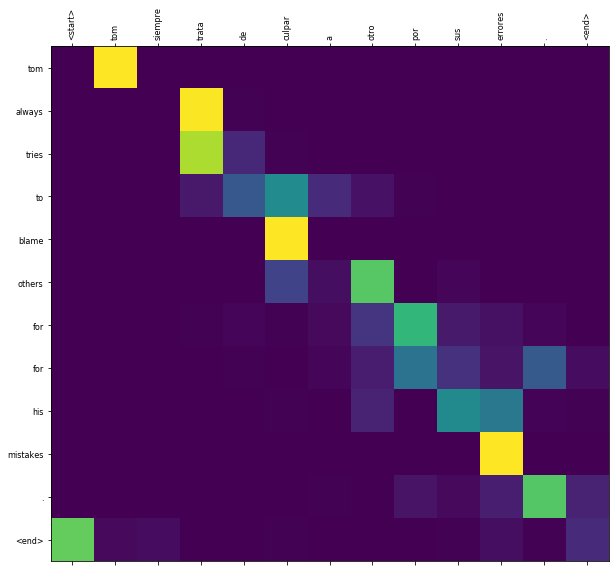

1/1 [==============================] - 0s 143ms/sample
->Input: <start> estamos acostumbrados a llevar zapatos . <end> 
->Predict: we are used to the shoes . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> we are accustomed to wearing shoes . <end> 
1/1 [==============================] - 1s 921ms/sample


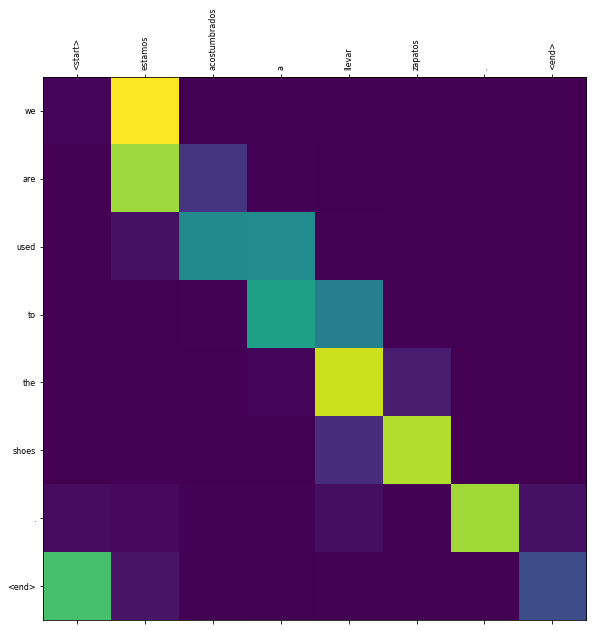

1/1 [==============================] - 0s 152ms/sample
->Input: <start> ahora tengo que hacer otra cosa . <end> 
->Predict: now have to do something else . . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i have to do something else now . <end> 
1/1 [==============================] - 1s 929ms/sample


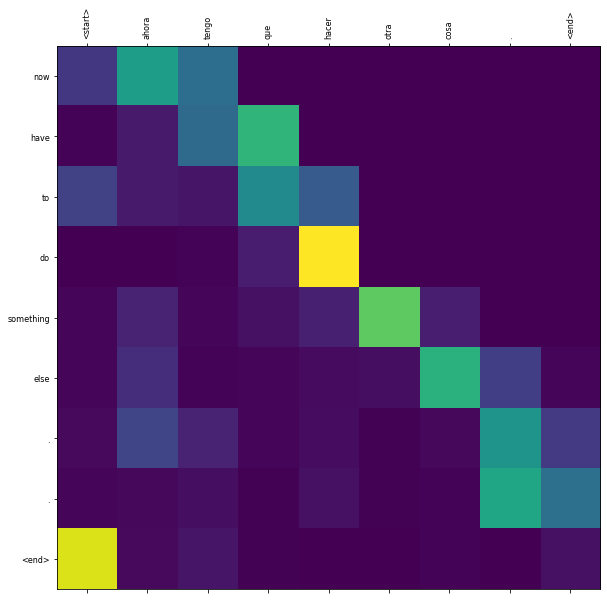

1/1 [==============================] - 0s 153ms/sample
->Input: <start> me pidio que bailara . <end> 
->Predict: i asked me to make . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> he asked me to dance . <end> 
1/1 [==============================] - 1s 942ms/sample


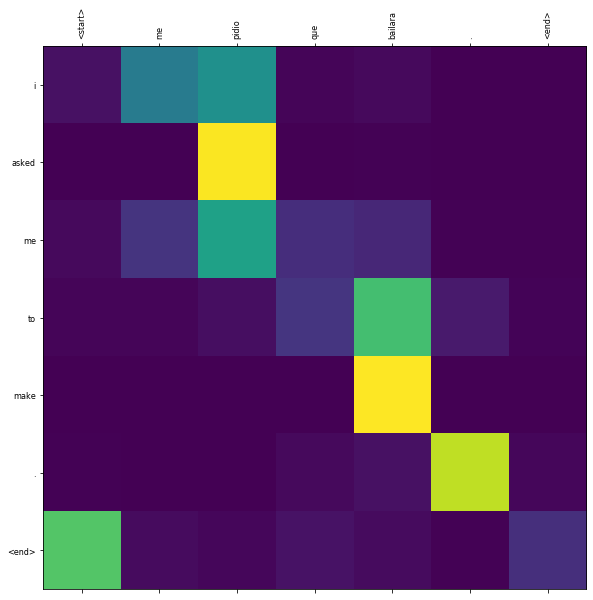

1/1 [==============================] - 0s 142ms/sample
->Input: <start> eso es cierto . <end> 
->Predict: that s true . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> that s true . <end> 
1/1 [==============================] - 1s 946ms/sample


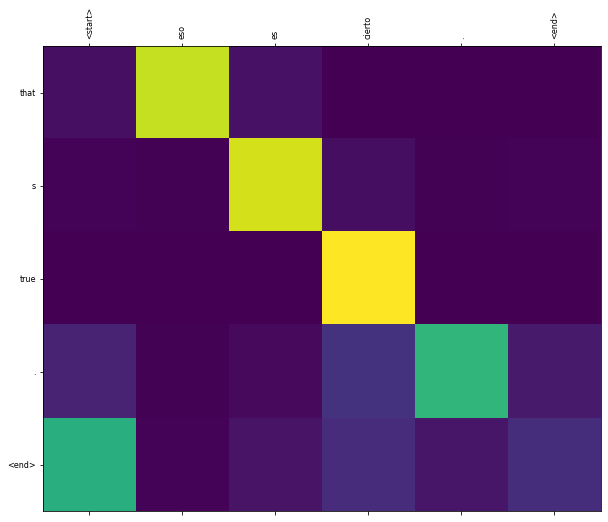

1/1 [==============================] - 0s 146ms/sample
->Input: <start> le robaron su auto en el estacionamiento . <end> 
->Predict: she was his car stolen in the parking lot . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> he had his car stolen in that parking lot . <end> 
1/1 [==============================] - 1s 952ms/sample


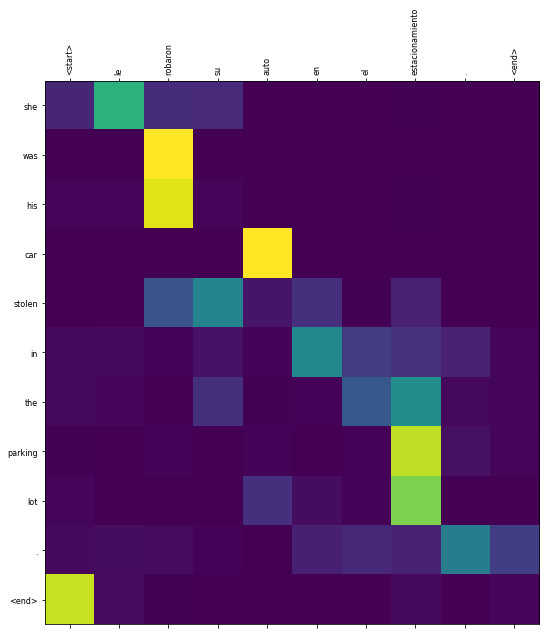

1/1 [==============================] - 0s 150ms/sample
->Input: <start> ¿ que comes el dia de navidad ? <end> 
->Predict: what do you eat for christmas day ? <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> what do you eat on christmas day ? <end> 
1/1 [==============================] - 1s 949ms/sample


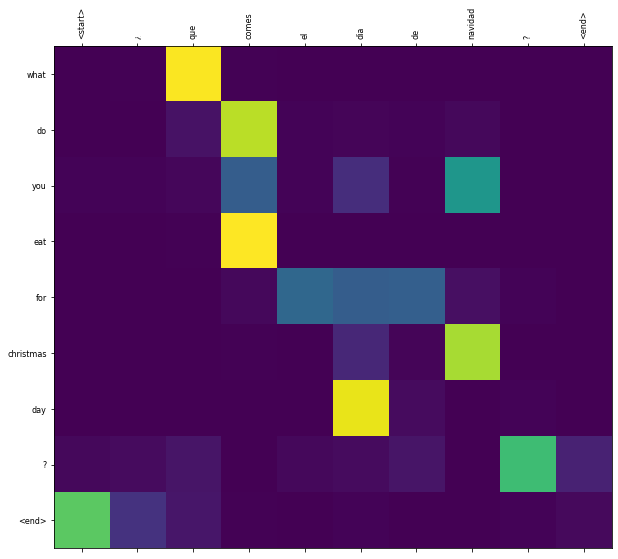

1/1 [==============================] - 0s 151ms/sample
->Input: <start> estan perfectamente . <end> 
->Predict: they re doing . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> they re fine . <end> 
1/1 [==============================] - 1s 952ms/sample


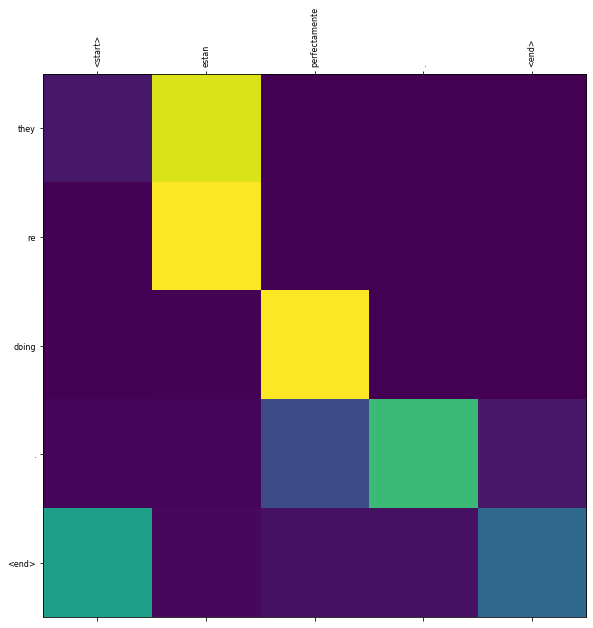

1/1 [==============================] - 0s 153ms/sample
->Input: <start> encontro la puerta cerrada . <end> 
->Predict: he found the door shut . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> he found the door closed . <end> 
1/1 [==============================] - 1s 981ms/sample


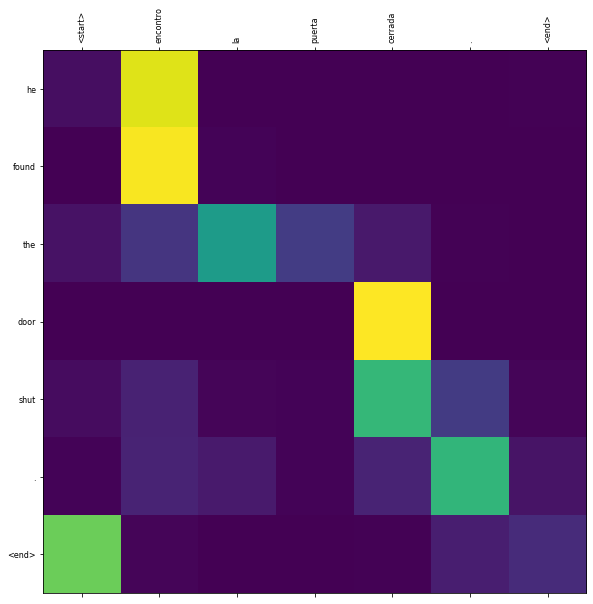

1/1 [==============================] - 0s 154ms/sample
->Input: <start> no te ofendas . tom se comporta asi con todos . <end> 
->Predict: don t get deceived . tom s going he to us . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> don t be offended . tom s that way with everyone . <end> 
1/1 [==============================] - 1s 951ms/sample


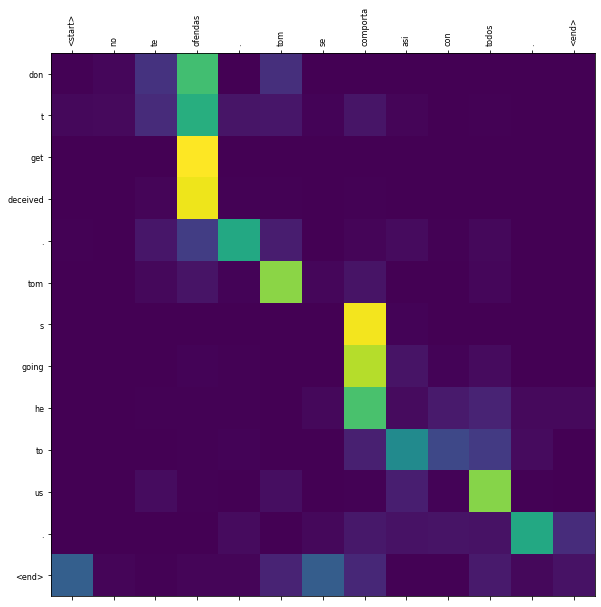

1/1 [==============================] - 0s 153ms/sample
->Input: <start> te sugiero que te escondas . <end> 
->Predict: i suggest you hide . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i suggest you hide . <end> 
1/1 [==============================] - 1s 979ms/sample


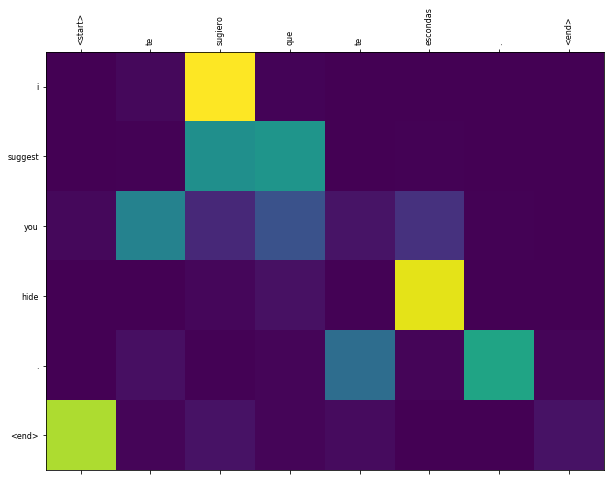

1/1 [==============================] - 0s 151ms/sample
->Input: <start> por favor come . tienes hambre , ¿ verdad ? <end> 
->Predict: you eat . you re hungry , please t you ? <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> please eat . you re hungry , aren t you ? <end> 
1/1 [==============================] - 1s 960ms/sample


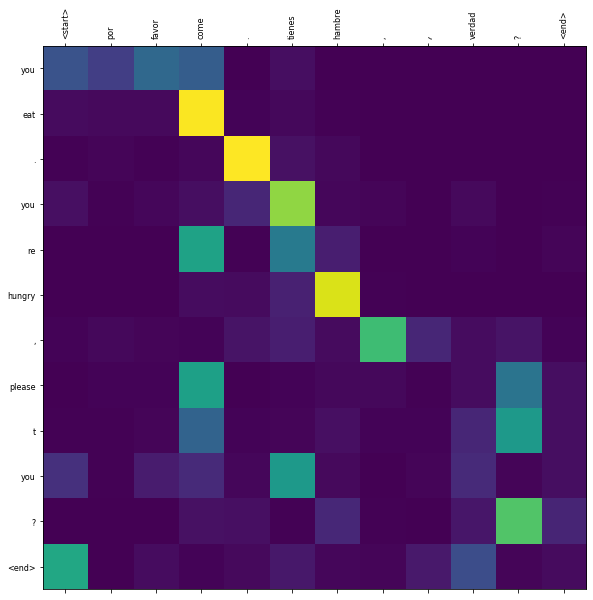

1/1 [==============================] - 0s 153ms/sample
->Input: <start> la vi cruzar la calle . <end> 
->Predict: i saw her cross the street . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i saw her crossing the street . <end> 
1/1 [==============================] - 1s 936ms/sample


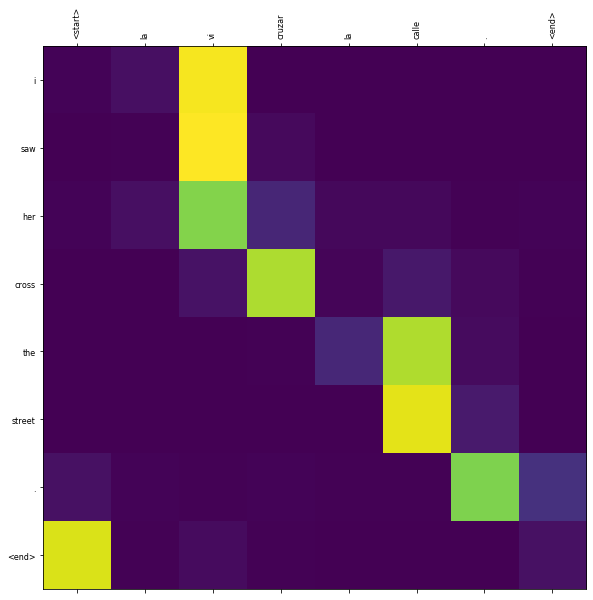

1/1 [==============================] - 0s 153ms/sample
->Input: <start> no menos de quinientos estudiantes estaban presentes . <end> 
->Predict: i one , you students were were present . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> no fewer than five hundred students were present . <end> 
1/1 [==============================] - 1s 945ms/sample


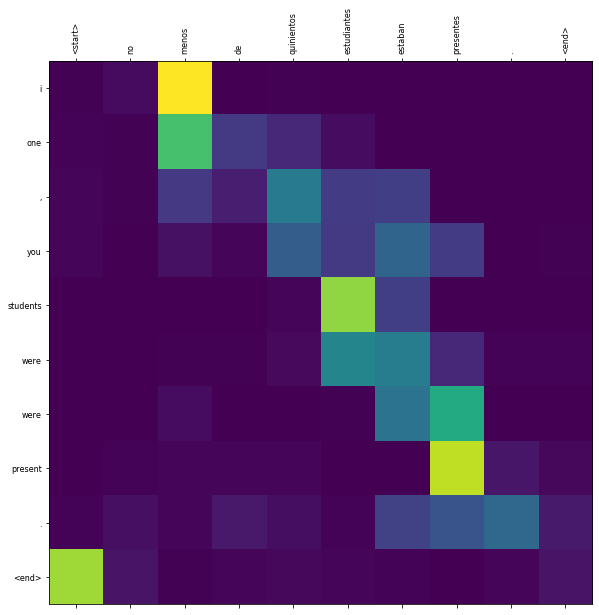

1/1 [==============================] - 0s 145ms/sample
->Input: <start> ¿ donde crees que seria el lugar mas seguro ? <end> 
->Predict: where do you think the other will ? be ? <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> where do you think the safest place would be ? <end> 
1/1 [==============================] - 1s 950ms/sample


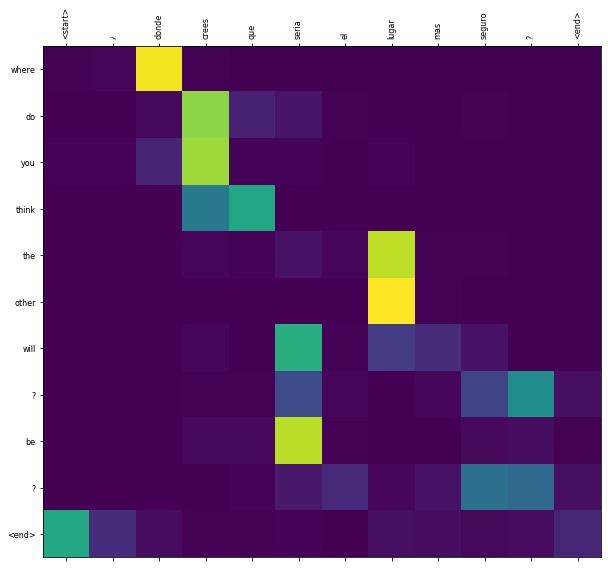

1/1 [==============================] - 0s 153ms/sample
->Input: <start> ¿ a que viene esto ? <end> 
->Predict: what is this going <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> why is this ? <end> 
1/1 [==============================] - 1s 943ms/sample


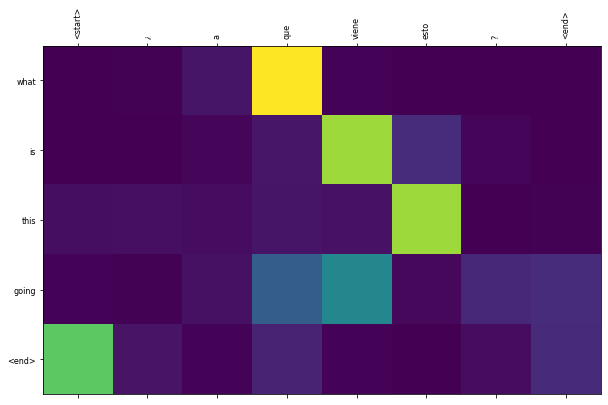

1/1 [==============================] - 0s 152ms/sample
->Input: <start> no tengo opcion . <end> 
->Predict: i have t have a choice . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i don t have a choice . <end> 
1/1 [==============================] - 1s 948ms/sample


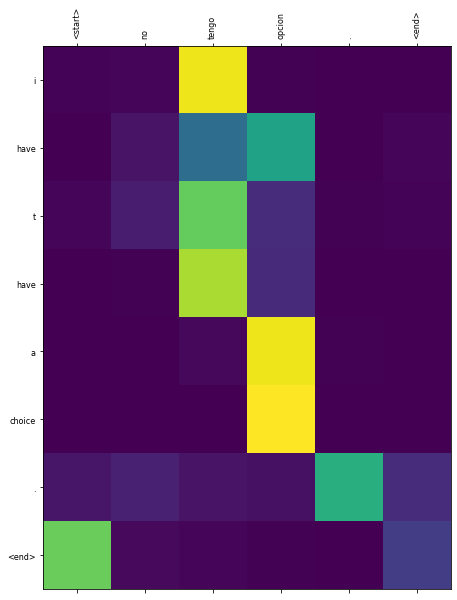

1/1 [==============================] - 0s 151ms/sample
->Input: <start> jugar a las cartas es divertido . <end> 
->Predict: playing s fun to play cards . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> it is fun to play cards . <end> 
1/1 [==============================] - 1s 917ms/sample


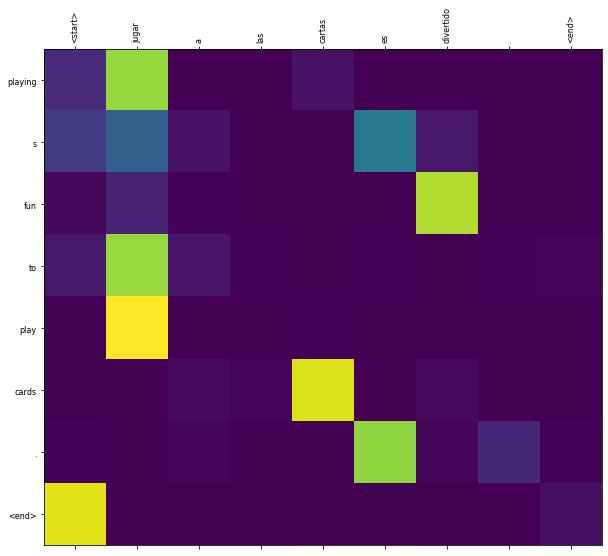

1/1 [==============================] - 0s 153ms/sample
->Input: <start> ella no te entiende . <end> 
->Predict: she doesn t understand you . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> she doesn t understand you . <end> 
1/1 [==============================] - 1s 888ms/sample


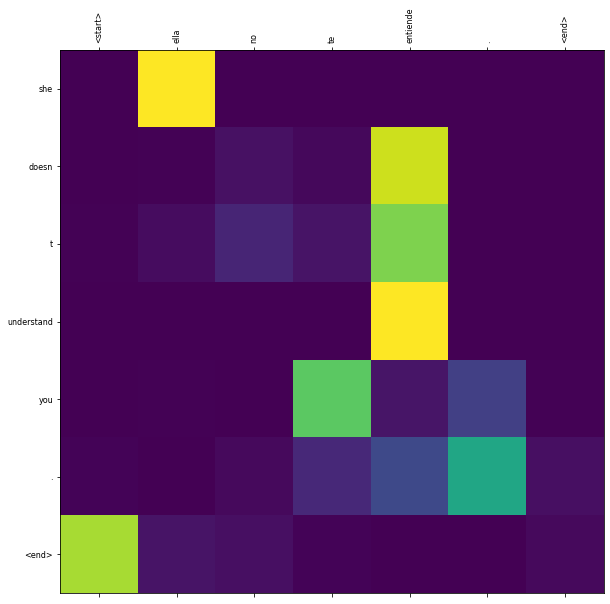

1/1 [==============================] - 0s 151ms/sample
->Input: <start> empezaron a besarse . <end> 
->Predict: they started kissing . <end> . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> they started kissing each other . <end> 
1/1 [==============================] - 1s 931ms/sample


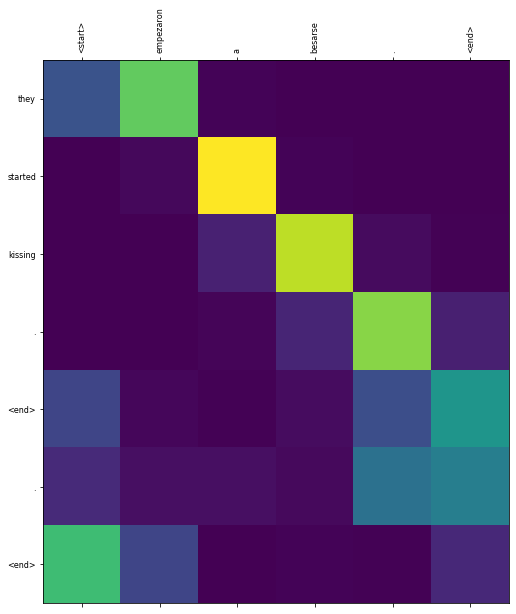

1/1 [==============================] - 0s 153ms/sample
->Input: <start> eso es terrible . <end> 
->Predict: that s terrible . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> that s terrible . <end> 
1/1 [==============================] - 1s 930ms/sample


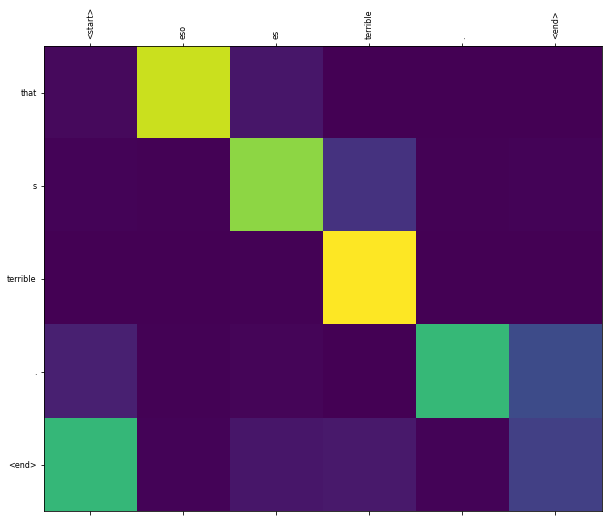

1/1 [==============================] - 0s 151ms/sample
->Input: <start> ¿ ahora estas contento ? <end> 
->Predict: are you happy now ? <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> are you happy now ? <end> 
1/1 [==============================] - 1s 899ms/sample


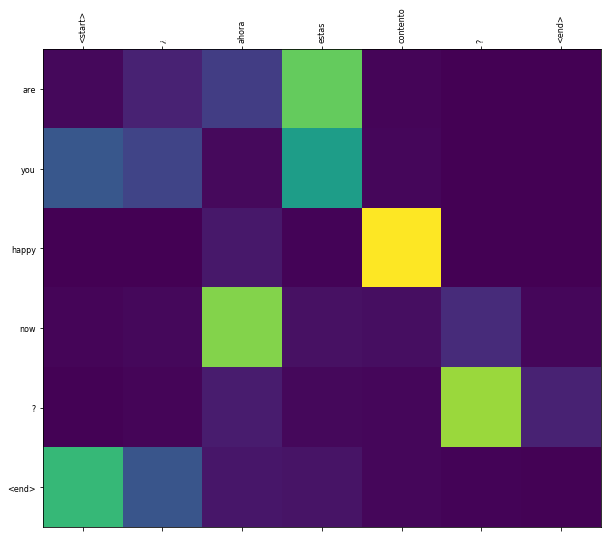

1/1 [==============================] - 0s 153ms/sample
->Input: <start> me alegro mucho de que hayas podido venir . <end> 
->Predict: i m very glad you could come . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i m really happy you could come . <end> 
1/1 [==============================] - 1s 923ms/sample


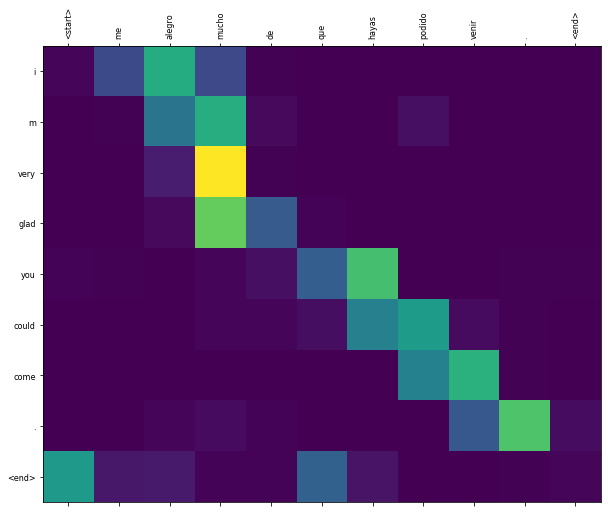

1/1 [==============================] - 0s 153ms/sample
->Input: <start> estamos cometiendo un gran error . <end> 
->Predict: we re making a big mistake . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> we re making a big mistake . <end> 
1/1 [==============================] - 1s 943ms/sample


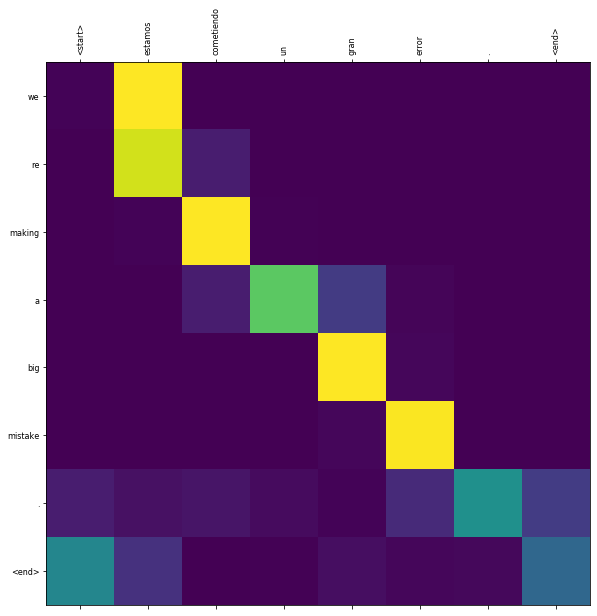

1/1 [==============================] - 0s 154ms/sample
->Input: <start> quiero algo de papel . <end> 
->Predict: i want some paper . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i want some paper . <end> 
1/1 [==============================] - 1s 906ms/sample


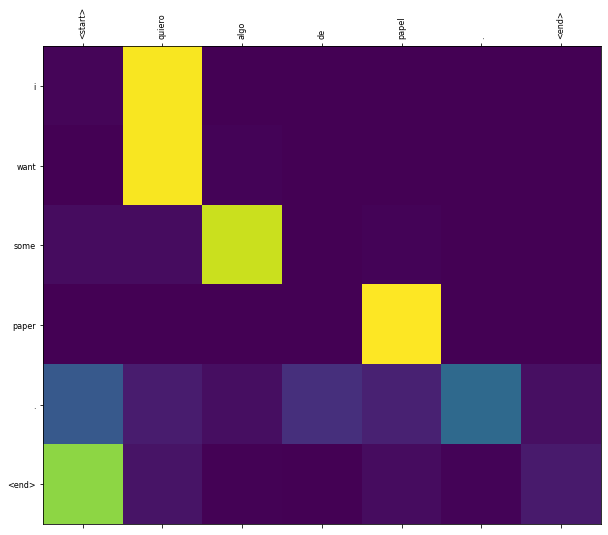

1/1 [==============================] - 0s 151ms/sample
->Input: <start> a veces le pongo un poco de sal . <end> 
->Predict: i sometimes get a little salt . . . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i sometimes put a little salt in it . <end> 
1/1 [==============================] - 1s 928ms/sample


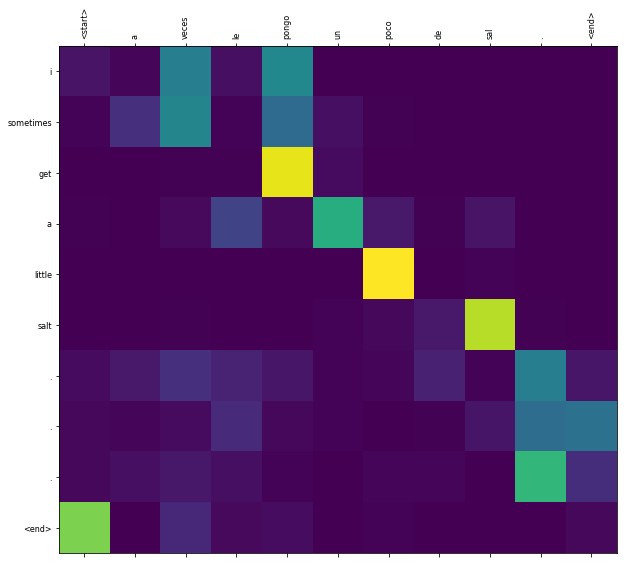

1/1 [==============================] - 0s 152ms/sample
->Input: <start> se por que lo hiciste . <end> 
->Predict: i know why did it . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i know you did it . <end> 
1/1 [==============================] - 1s 923ms/sample


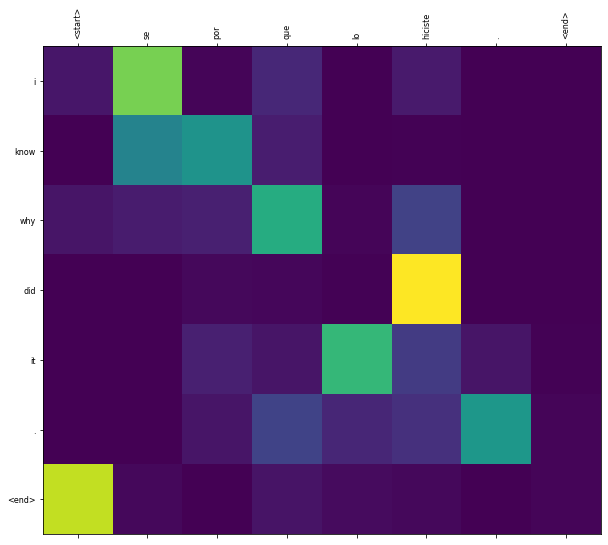

In [0]:
for id_sent in range(10,40):
    # id_sent = 2
    atn = visualize_attention(9,[input_tensor_val[id_sent:id_sent+1], target_tensor_val[id_sent:id_sent+1, :-1]])

1/1 [==============================] - 0s 153ms/sample
->Input: <start> me acuerdo que ella llevaba un sombrero verde . <end> 
->Predict: i remember that she wore a green hat . <end> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
->Real target: <start> i remember that she wore a green hat . <end> 
1/1 [==============================] - 1s 887ms/sample


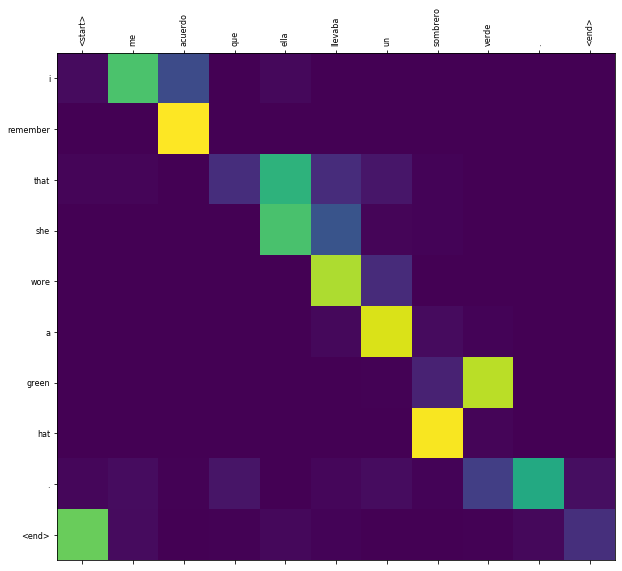

In [0]:
id_sent = 4
atn = visualize_attention(9,[input_tensor_train[id_sent:id_sent+1], target_tensor_train[id_sent:id_sent+1, :-1]])

In [0]:
[input_tensor_train[id_sent:id_sent+1], target_tensor_train[id_sent:id_sent+1, :-1]]

In [0]:
atn[1][0][:12,:15]

array([[2.94540897e-02, 7.15724885e-01, 2.27179736e-01, 3.65146575e-03,
        2.27181129e-02, 8.66427785e-04, 2.77259125e-04, 6.51357332e-05,
        1.83038139e-06, 3.23570857e-05, 2.87094390e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.72623268e-04, 2.17675138e-03, 9.95973289e-01, 1.21555931e-03,
        1.33599096e-05, 2.25842086e-04, 1.50809483e-05, 4.02655360e-06,
        4.26532353e-07, 9.11880704e-07, 2.10272401e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.46068120e-02, 1.27868457e-02, 1.05778698e-03, 1.30060032e-01,
        6.43661857e-01, 1.26699209e-01, 5.94421029e-02, 8.47767200e-03,
        2.18166388e-04, 1.44654745e-03, 1.54297729e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.64653238e-03, 8.11243779e-04, 2.96556042e-04, 3.41484486e-03,
        7.11879849e-01, 2.57975340e-01, 1.32505950e-02, 8.72027874e-03,
        5.06064607e-05, 4.01963043e-0

In [0]:
input_tensor_train.shape

(83274, 53)